# Data from a gamma detector (Eu152)
Indentify and extract peaks from the data
Note you will need a copy of the Eu152.mat file which can be downloaded from where you got this file

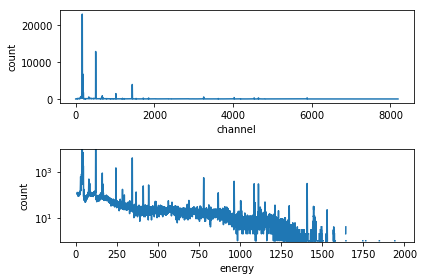

In [9]:
# load plotting system
%matplotlib inline
import matplotlib.pyplot as plt
# add numpy
import numpy as np
# use scipy routine to load a matlab format datafile
from scipy.io import loadmat
Eu152=loadmat('Eu152.mat',mat_dtype=True,variable_names=['channel2','count2','energy2'])
# convert the data just loaded into three arrays
channel = np.array(Eu152['channel2'][0],dtype=int)
count = Eu152['count2'][0]
energy = Eu152['energy2'][0]
# plot the data to see what was there, linear and logy plot
p1 = plt.subplot(211)
p1.plot(channel,count)
p1.set_xlabel('channel')
p1.set_ylabel('count')
p2 = plt.subplot(212)
p2.plot(energy,count)
p2.set_xlabel('energy')
p2.set_ylabel('count')
p2.semilogy()
p2.set_ylim([0.9,1e4])
plt.tight_layout()
plt.show()

## Now zoom into 800 - 3000 in channel numbers

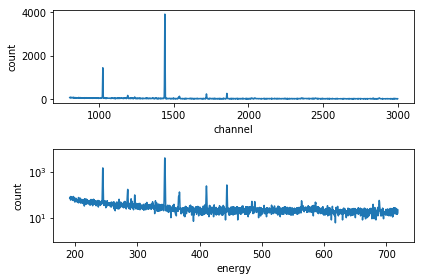

In [10]:
p1 = plt.subplot(211)
p1.plot(channel[800:3001],count[800:3001])
p1.set_xlabel('channel')
p1.set_ylabel('count')
p2 = plt.subplot(212)
p2.plot(energy[800:3001],count[800:3001])
p2.set_xlabel('energy')
p2.set_ylabel('count')
p2.semilogy()
p2.set_ylim([0.9,1e4])
plt.tight_layout()
plt.show()

### Correct for efficiency: the gamma detector is not equally efficient for all energies

In [11]:
calibEff = {59.5  : 0.042293, ## {energy : efficiency} for several points in the detector's range
            661.7 : 0.012586, 
            88.0  : 0.047077, 
            898.0 : 0.008659,
            122.1 : 0.051100, 
            1173.2: 0.006979,
            165.9 : 0.042985, 
            1332.0: 0.006235,
            391.7 :0.019621, 
            1836.1:0.005067}
energyList = []
invEffList = [] # 1/efficiency of the point
calibEList = calibEff.keys()
for en in sorted(calibEff.keys()): # loop over energies in accending order
    energyList.append(en)
    invEffList.append(1./calibEff[en])
# define a function to interpolate between the energy points
def inverseEff(en):
    if(en<energyList[0]): return invEffList[0] # energy is below 1st listed point
    for i in range(len(energyList)-1):
        if(en>=energyList[i] and en<energyList[i+1]): #  energyList[i+1] is above en and energyList[i] is below
            # average invEff weighted by the delta channel number
            # y = y' + (x-x')*dy/dx where x' is a point with a known y' value
            return invEffList[i] + (en-energyList[i])*(invEffList[i+1]-invEffList[i])/(energyList[i+1]-energyList[i])
    return invEffList[-1] # bigger than biggest value

### Demonstrate 1/eff scaling between points
Sanity check to see that the code works between the points properly

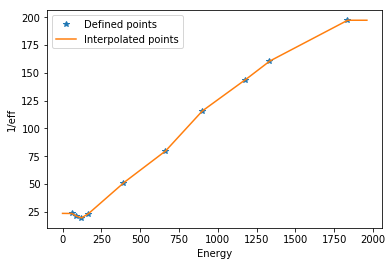

In [12]:
p1 = plt.subplot(111)
p1.errorbar(energyList,invEffList,fmt="*",label="Defined points")
ie = np.array([inverseEff(en) for en in energy])
p1.errorbar(energy,ie,fmt="-",label="Interpolated points")
p1.set_xlabel('Energy')
p1.set_ylabel('1/eff')
p1.legend()
plt.show()

## Scale data points with inverse efficiency
Scale Poisson errors by efficiency factor as well

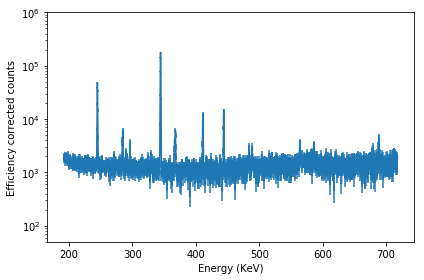

In [13]:
p1 = plt.subplot(211)
corrCount = ie*count # correct for efficiency back to "true" counts
corrErr = ie*np.sqrt(count) # scale error the same
p1 = plt.subplot(111)
p1.errorbar(energy[800:3000],corrCount[800:3000],yerr=corrErr[800:3000],fmt="-")
p1.set_xlabel('Energy (KeV)')
p1.set_ylabel('Efficiency corrected counts')
p1.semilogy()
p1.set_ylim([50,1e6])
plt.tight_layout()
plt.show()

### Find local maxima
Define as where one bin is more than both it's neigbours and 10^4 corrected counts

In [14]:
def maxBins(energy,corrCount):
    binMax = []
    for i in range(1,len(energy)-1): # start at 1 and go to length-2 so there is a bin either side...
        if(corrCount[i]>1e4 and corrCount[i-1]<corrCount[i] and corrCount[i+1]<corrCount[i]):
            binMax.append(i)
    return binMax
maxBinList = maxBins(energy,corrCount)

### Fit each of the maxima found

bin 1022 energy   244.7 KeV corrected counts   47388
A       = 45478.895593 +- 744.324568
mean    = 244.668193 +- 0.004509
Sigma   = 0.326916 +- 0.003763
B       = 1413.702340 +- 54.638452


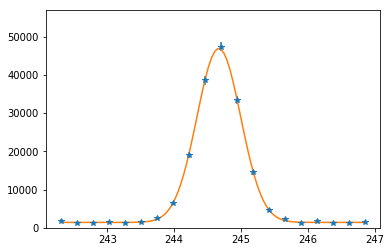

bin 1438 energy   344.3 KeV corrected counts  176317
A       = 173287.941053 +- 1877.202291
mean    = 344.288573 +- 0.003258
Sigma   = 0.364770 +- 0.002520
B       = 1256.858142 +- 79.420254


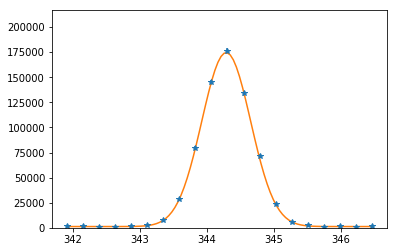

bin 1717 energy   411.1 KeV corrected counts   12617
A       = 11433.736696 +- 634.669691
mean    = 411.128852 +- 0.019854
Sigma   = 0.401646 +- 0.018336
B       = 1009.344981 +- 90.156860


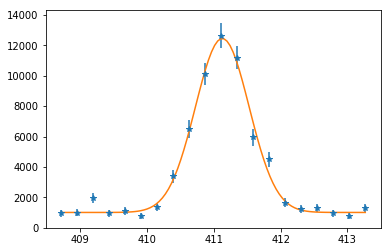

bin 1854 energy   443.9 KeV corrected counts   14796
A       = 13200.418311 +- 744.466064
mean    = 443.993842 +- 0.019785
Sigma   = 0.398914 +- 0.017836
B       = 972.387641 +- 96.703527


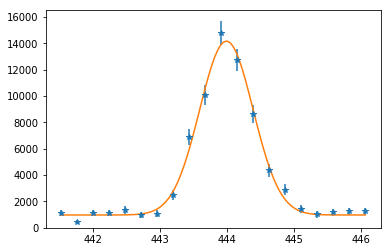

In [15]:
# defined function to fit Gaussian + flat background
def GaussP0(x,A,m,s,B):
    return A*np.exp(-1*(x-m)**2/(2*s**2)) + B
from scipy.optimize import curve_fit
# define starting values
window = 10 # window around peak in bins
for b in maxBinList:
    if(b<800 or b>3000): continue # outside range considered 
    print("bin {:4} energy {:7.1f} KeV corrected counts {:7.0f}".format(b,energy[b],corrCount[b]))
    A = corrCount[b] # Amount of Gaussian
    m = energy[b] # position of peak
    s = 0.5 # estimate os width
    B = 1e3 # estimate of background
    x = energy[b-window:b+window] # just fit in bin bMax +- window
    y = corrCount[b-window:b+window] # same range for corrected counts
    dy = corrErr[b-window:b+window] # and errors
    popt, pcov = curve_fit(GaussP0,x,y,sigma=dy,p0=[A,m,s,B])
    # print the results
    for (name,i) in [('A',0),('mean',1),('Sigma',2),('B',3)]:
        print("{:7} = {:f} +- {:f}".format(name,popt[i],np.sqrt(pcov[i][i])))
    A = popt[0]
    m = popt[1]
    s = popt[2]
    B = popt[3]
    plt.errorbar(x,y,dy,fmt="*")
    smoothx = np.linspace(x[0],x[-1],100)
    plt.plot(smoothx,GaussP0(smoothx,A,m,s,B))
    plt.ylim([0,1.25*A]) # start at zero and max sure enough space for peak
    plt.show()
    
